# Taylor-series: Lorenz96 problem

The Lorenz96 problem is a common differential equation.

In [1]:
"""Benchmark all Taylor-series estimators on the Fitzhugh-Nagumo problem."""

import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.config import config

from probdiffeq.util.doc_util import notebook

config.update("jax_platform_name", "cpu")

In [2]:
def load_results():
    """Load the results from a file."""
    return jnp.load("./results.npy", allow_pickle=True)[()]


def choose_style(label):
    """Choose a plotting style for a given algorithm."""
    if "doubling" in label.lower():
        return {"color": "C3", "linestyle": "dotted"}
    if "unroll" in label.lower():
        return {"color": "C2", "linestyle": "dashdot"}
    if "taylor" in label.lower():
        return {"color": "C0", "linestyle": "solid"}
    if "forward" in label.lower():
        return {"color": "C1", "linestyle": "dashed"}
    msg = f"Label {label} unknown."
    raise ValueError(msg)


def plot_results(axis_compile, axis_perform, results):
    """Plot the results."""
    style_curve = {"alpha": 0.85, "markersize": 5}
    style_area = {"alpha": 0.15}
    for label, wp in results.items():
        style = choose_style(label)

        inputs = wp["arguments"]
        work_compile = wp["work_compile"]
        work_mean, work_std = wp["work_mean"], wp["work_std"]

        if "doubling" in label:
            num_repeats = jnp.diff(jnp.concatenate((jnp.ones((1,)), inputs)))
            inputs = jnp.arange(1, jnp.amax(inputs) * 1)
            work_compile = _adaptive_repeat(work_compile, num_repeats)
            work_mean = _adaptive_repeat(work_mean, num_repeats)
            work_std = _adaptive_repeat(work_std, num_repeats)
            # axis_perform.set_xticks(inputs[::2])

        axis_compile.semilogy(inputs, work_compile, label=label, **style, **style_curve)

        range_lower, range_upper = work_mean - work_std, work_mean + work_std
        axis_perform.semilogy(inputs, work_mean, label=label, **style, **style_curve)
        axis_perform.fill_between(
            inputs, range_lower, range_upper, **style, **style_area
        )

    axis_compile.set_xlim((1, 17))
    # axis_perform.set_yticks((1e-6, 1e-5, 1e-4))
    # axis_perform.set_ylim((7e-7, 1.5e-4))
    return axis_compile, axis_perform


def _adaptive_repeat(xs, ys):
    """Repeat the doubling values correctly to create a comprehensible plot."""
    zs = []
    for x, y in zip(xs, ys):
        zs.extend([x] * int(y))
    return jnp.asarray(zs)

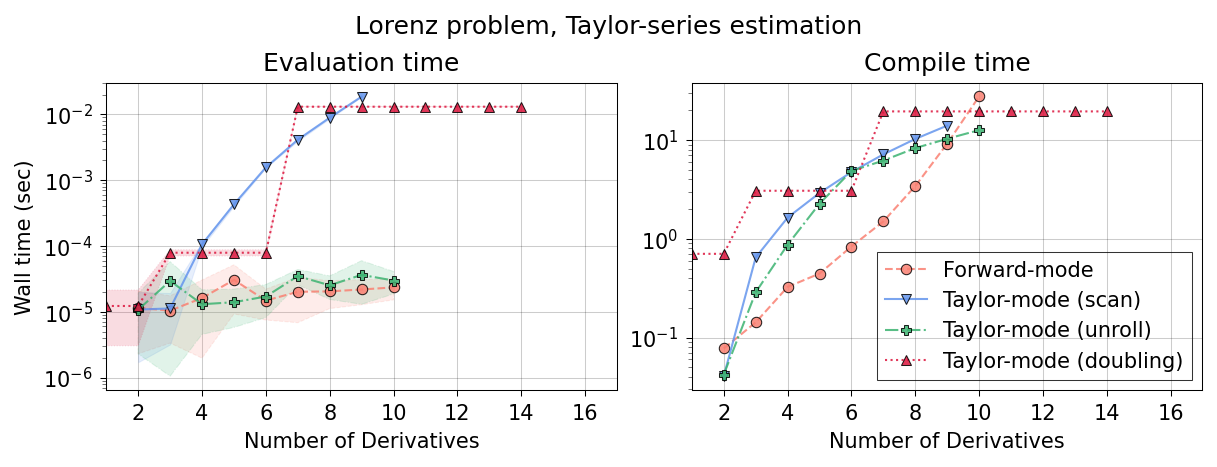

In [3]:
plt.rcParams.update(notebook.plot_config())

fig, (axis_perform, axis_compile) = plt.subplots(
    ncols=2, dpi=150, figsize=(8, 3), sharex=True, constrained_layout=True
)
fig.suptitle("Lorenz problem, Taylor-series estimation")

results = load_results()
axis_compile, axis_perform = plot_results(axis_compile, axis_perform, results)

axis_compile.set_title("Compile time")
axis_perform.set_title("Evaluation time")
axis_compile.legend(loc="lower right")
axis_compile.set_xlabel("Number of Derivatives")
axis_perform.set_xlabel("Number of Derivatives")
axis_perform.set_ylabel("Wall time (sec)")
axis_perform.grid()
axis_compile.grid()

plt.show()